In [1]:
import numpy as np
np.set_printoptions(linewidth=150)
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy import interpolate
import SINN_functions as sf
import tensorflow as tf

In [3]:
def Bezier3(p1,p2,p3):
    return lambda t: (1-t)**2*p1 + 2*(1-t)*t*p2 + t**2*p3

def Bezier4(p1,p2,p3,p4):
    return lambda t: (1-t)**3*p1 + 3*(1-t)**2*t*p2 + 3*(1-t)*t**2*p3 + t**3*p4

def SplineLength(s,n=10):
    t = np.linspace(0,1,n).reshape(-1,1)
    p = s(t)
    return np.sum(np.sqrt(np.sum((p[1:]-p[:-1])**2,axis=1)))

def GetShape(pF,pC):
    b = []
    for i in range(4):
        b.append(Bezier3(pF[i],pC[i],pF[(i+1)%4]))
    return b

def GetCentre(pF):
    k = (pF[2,1]-pF[0,1])/(pF[2,0]-pF[0,0]) - (pF[3,1]-pF[1,1])/(pF[3,0]-pF[1,0])
    b = (pF[2,1]-pF[0,1])/(pF[2,0]-pF[0,0])*pF[0,0] - (pF[3,1]-pF[1,1])/(pF[3,0]-pF[1,0])*pF[1,0] + pF[1,1] - pF[0,1]
    x = b/k
    y = (pF[2,1]-pF[0,1])/(pF[2,0]-pF[0,0])*x + pF[0,1]
    return np.array([x,y])

def GenerateGridMesh(s1,s2,na,nb,onBoundary=True):
    ta = np.linspace(0,1,na).reshape(-1,1)
    tb = np.linspace(0,1,nb).reshape(-1,1,1)
    e1 = s1(ta)
    e2 = s2(ta)
    nodes = e1 + (e2-e1)*tb
    nodes = nodes.reshape(-1,2)
    if onBoundary:
        boundaryNodes = np.arange(na)
    else:
        boundaryNodes = np.array([],dtype=int)
    elements = np.concatenate([
        np.arange(na*nb).reshape(nb,na).T[:-1,:-1].reshape(-1,1),
        np.arange(na*nb).reshape(nb,na).T[1:,:-1].reshape(-1,1),
        np.arange(na*nb).reshape(nb,na).T[:-1,1:].reshape(-1,1),
        np.arange(na*nb).reshape(nb,na).T[1:,1:].reshape(-1,1)
    ],axis=1)
    return nodes, boundaryNodes, elements

# def GenerateGridMesh2(pB,na,nb,onBoundary=[]):
#     xi,eta = np.meshgrid(np.linspace(-1,1,na),np.linspace(-1,1,nb))
#     xi = xi.reshape(n,n,1)
#     eta = eta.reshape(n,n,1)


#     N = np.concatenate([
#         0.25 * (1 - xi) * (1 - eta) * (-1 - xi - eta),
#         0.25 * (1 + xi) * (1 - eta) * (-1 + xi - eta),
#         0.25 * (1 + xi) * (1 + eta) * (-1 + xi + eta),
#         0.25 * (1 - xi) * (1 + eta) * (-1 - xi + eta),
#         0.5 * (1 - xi**2) * (1 - eta),
#         0.5 * (1 + xi) * (1 - eta**2),
#         0.5 * (1 - xi**2) * (1 + eta),
#         0.5 * (1 - xi) * (1 - eta**2)
#     ],axis=-1)
#     N = np.expand_dims(N,axis=-2)

#     p = np.array([[0,0],[1,0],[1,1],[0,1],[0.5,-0.1],[1.1,0.5],[0.5,1.1],[-0.1,0.5]])
#     grid = N @ p

def MergeMeshes(nodes_arr, boundaryNodes_arr, elements_arr):
    all_nodes = np.concatenate(nodes_arr)
    nodes, unique_indices = np.unique(all_nodes.round(5), axis=0, return_inverse=True)
    offset = 0
    boundary_start_end = []
    for i in range(len(nodes_arr)):
        elements_arr[i] = unique_indices[elements_arr[i] + offset]
        if boundaryNodes_arr[i].shape[0] != 0:
            boundaryNodes_arr[i] = unique_indices[boundaryNodes_arr[i] + offset]
            boundary_start_end.append([boundaryNodes_arr[i][0],boundaryNodes_arr[i][-1],i])
        offset += len(nodes_arr[i])

    elements = np.concatenate(elements_arr)
    boundary_continue = boundary_start_end[0][1]
    boundaryNodes_arr_sorted = [boundaryNodes_arr[boundary_start_end[0][2]][1:]]
    boundary_start_end = np.array(boundary_start_end[1:],dtype=int)
    n_boundary = boundary_start_end.shape[0]
    for i in range(n_boundary):
        j,k = np.where(boundary_start_end[:,:2] == boundary_continue)
        j = j[0]
        if k[0]==0:
            boundaryNodes_arr_sorted.append(boundaryNodes_arr[boundary_start_end[j,2]][1:])
            boundary_continue = boundary_start_end[j,1]
        else:
            boundaryNodes_arr_sorted.append(boundaryNodes_arr[boundary_start_end[j,2]][:0:-1])
            boundary_continue = boundary_start_end[j,0]
        boundary_start_end = np.delete(boundary_start_end,j,axis=0)
        
    boundaryNodes = np.concatenate(boundaryNodes_arr_sorted)
    return nodes, boundaryNodes, elements

def PlotMesh(nodes, boundaryNodes, elements):
    plt.scatter(nodes[:,0],nodes[:,1])
    for el in elements:
        plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [5]:
# FEM with variable grid -> K_el calculation
# K_el = int(int(B.T @ A @ B * det(J),d_xi),d_eta)

# B precalculation
def GetB_xi_eta(r):
    # Constructs the function B(xi,eta) for a given r

    def f(xi,eta):
        N1_xi = (eta-1)/4
        N2_xi = (1-eta)/4
        N3_xi = -(1+eta)/4
        N4_xi = (1+eta)/4

        N1_eta = (xi-1)/4
        N2_eta = -(1+xi)/4
        N3_eta = (1-xi)/4
        N4_eta = (1+xi)/4

        B = np.concatenate([
            np.concatenate([N1_xi*np.eye(r), N2_xi*np.eye(r), N3_xi*np.eye(r), N4_xi*np.eye(r)], axis=1),
            np.concatenate([N1_eta*np.eye(r), N2_eta*np.eye(r), N3_eta*np.eye(r), N4_eta*np.eye(r)], axis=1)
        ], axis=0)
        return B
    return f

# Precalculate Gauss points and weights
def GetGaussPoints(n_gauss):
    xi = np.zeros((n_gauss,n_gauss))
    eta = np.zeros((n_gauss,n_gauss))
    weight = np.zeros((n_gauss,n_gauss))
    if n_gauss == 1:
        xi[0,0] = 0
        eta[0,0] = 0
        weight[0,0] = 4
    elif n_gauss == 2:
        for i in range(2):
            for j in range(2):
                xi[i,j] = -np.sqrt(1/3)*(-1)**i
                eta[i,j] = -np.sqrt(1/3)*(-1)**j
                weight[i,j] = 1
    else:
        raise ValueError(f'Gauss points not supported for n_gauss = {n_gauss}')
    return xi, eta, weight

# Precalculate B for numerical integration
def GetB(r,xi,eta):
    # r = number of latent variables
    # n_gauss = number of gauss points for numerical integration
    
    B_xi_eta = GetB_xi_eta(r)
    B = np.zeros((xi.shape[0],xi.shape[1],r*2, r*4))
    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            B[i,j,:,:] = B_xi_eta(xi[i,j],eta[i,j])
    return B

# Define general function for |J(xi,eta)| - Determinant of the Jacobian matrix
def GetM_J(xi,eta):
    # M_J is defined such that J(xi,eta) = M_J(xi,eta) @ nodes
    # nodes = [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    M_J = np.array([[eta-1,1-eta,-1-eta,1+eta],[xi-1,-1-xi,1-xi,1+xi]])/4
    return np.transpose(M_J,(2,3,0,1))


# Define general function for K_el using gaussian integrations
def GetK_el_sub(B,A,J,xi,eta,weight):
    det_J = np.linalg.det(J)[:,:,np.newaxis,np.newaxis]
    B_T = np.transpose(B,(0,1,3,2))
    K_partial = np.matmul(B_T, np.matmul(A,B)) * det_J * np.expand_dims(weight,axis=(2,3))
    K_el = np.sum(K_partial, axis=(0,1))
    return K_el

def GetK_el(A,nodes,n_gauss):
    # A = [[A11,A12],[A12,A22]]
    # nodes = [[x1,y1],[x2,y2],...]
    # n_gauss = number of gauss points for numerical integration
    
    xi,eta,weight = GetGaussPoints(n_gauss)
    r = int(A.shape[0]/2)
    B = GetB(r,xi,eta)
    J = GetM_J(xi,eta) @ nodes
    G = np.linalg.inv(J)
    B = G @ B
    K_el = GetK_el_sub(B,A,J,xi,eta,weight)
    return K_el

def SolveFEM(nodes, elements, boundary_nodes, BCfunc, internal_nodes, n_gauss, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A
    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el(A_l,nodes_el,n_gauss)
        K[Y_idx,X_idx] += K_el

    # Apply Dirichlet BC
    x_BC = nodes[boundary_nodes,0]
    y_BC = nodes[boundary_nodes,1]
    alpha = np.arctan2(y_BC-0.5,x_BC-0.5)
    l_BC = BCfunc(alpha)
    bc_idx = [[r*i+j for j in range(r)] for i in boundary_nodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internal_nodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internal_nodes,:] = l_internal
    l[boundary_nodes,:] = l_BC.reshape(-1,r)
    return l

In [6]:
def GenerateGridMesh2(pB,na,nb,onBoundary=True):
    xi,eta = np.meshgrid(np.linspace(-1,1,na),np.linspace(-1,1,nb))
    xi = xi.reshape(na,nb,1)
    eta = eta.reshape(na,nb,1)


    N = np.concatenate([
        0.25 * (1 - xi) * (1 - eta) * (-1 - xi - eta),
        0.25 * (1 + xi) * (1 - eta) * (-1 + xi - eta),
        0.25 * (1 + xi) * (1 + eta) * (-1 + xi + eta),
        0.25 * (1 - xi) * (1 + eta) * (-1 - xi + eta),
        0.5 * (1 - xi**2) * (1 - eta),
        0.5 * (1 + xi) * (1 - eta**2),
        0.5 * (1 - xi**2) * (1 + eta),
        0.5 * (1 - xi) * (1 - eta**2)
    ],axis=-1)
    N = np.expand_dims(N,axis=-2)

    grid = N @ pB
    nodes = grid.reshape(-1,2)

    # Define elements
    elements = np.concatenate([
        np.arange(na*nb).reshape(nb,na).T[:-1,:-1].reshape(-1,1),
        np.arange(na*nb).reshape(nb,na).T[1:,:-1].reshape(-1,1),
        np.arange(na*nb).reshape(nb,na).T[:-1,1:].reshape(-1,1),
        np.arange(na*nb).reshape(nb,na).T[1:,1:].reshape(-1,1)
    ],axis=1)

    if onBoundary:
        boundaryNodes = np.arange(na)
    else:
        boundaryNodes = np.array([],dtype=int)

    return nodes, boundaryNodes, elements

8 8 5


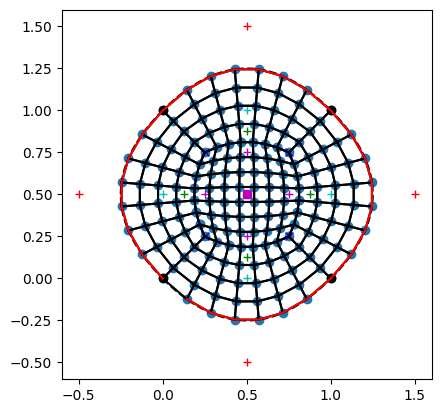

In [7]:
# Code to generate paramtric 2D mesh with quadrilateral elements

# Define the parametric domain
# Fixed points
pF = np.array([[0,0],[1,0],[1,1],[0,1]])
# Control points
pC = np.array([[0.5,-0.5],[1.5,0.5],[0.5,1.5],[-0.5,0.5]])
# Define internal quadrilateral
C = GetCentre(pF)
k = 0.5
pI = np.array([pF[i] + k*(C-pF[i]) for i in range(4)])
pCIl = np.array([(pI[i] + pI[(i+1)%4])/2 for i in range(4)])
pCIs = np.array([pC[i] + k*(C-pC[i]) for i in range(4)])
pCI = (pCIl+pCIs)/2

# Define Mesh
# sI = GetShape(pI,np.concatenate([(pI[:-1]+pI[1:])/2,(pI[0:1]+pI[-1:])/2],0))
sI = GetShape(pI,pCI)
sB = GetShape(pF,pC)


# Plot the parametric domain
plt.plot(pF[:,0],pF[:,1],'ko'
         ,pC[:,0],pC[:,1],'r+'
         ,pI[:,0],pI[:,1],'bx'
         ,pCI[:,0],pCI[:,1],'g+'
         ,pCIl[:,0],pCIl[:,1],'m+'
         ,pCIs[:,0],pCIs[:,1],'c+')
plt.scatter(C[0],C[1],marker='s',color='m')
n=100
t = np.linspace(0,1,n).reshape(-1,1)
for i in range(4):
    s = sB[i](t)
    plt.plot(s[:,0],s[:,1],'k--')
    s = sI[i](t)
    plt.plot(s[:,0],s[:,1],'b--')

plt.gca().set_aspect('equal', adjustable='box')

dx = 0.15
lengthB = [SplineLength(sB[i]) for i in range(4)]
lengthC = [np.sqrt(np.sum((pF[i]-pI[i])**2)) for i in range(4)]

na = int(max(lengthB[::2])//dx)+1
nb = int(max(lengthB[1::2])//dx)+1
nc = 2*int(max(lengthC)//dx)+1
print(na,nb,nc)

# Generate the mesh
pBs = [np.array([sB[i_grid](0),sB[i_grid](1),sI[i_grid](1),
                sI[i_grid](0),sB[i_grid](0.5),(sB[i_grid](1)+sI[i_grid](1))/2,
                sI[i_grid](0.5),(sB[i_grid](0)+sI[i_grid](0))/2])
                for i_grid in range(4)]
pBI = np.array([ sI[i](0) for i in range(4) ] + [ sI[i](0.5) for i in range(4) ])
ns = [na,nb,na,nb]
nodes_arr, boundaryNodes_arr, elements_arr = zip(*[GenerateGridMesh2(pBs[i_grid],ns[i_grid],nc) for i_grid in range(4)])
nodesI, boundaryNodesI, elementsI = GenerateGridMesh2(pBI,na,nb,onBoundary=False)
nodes_arr = list(nodes_arr) + [nodesI]
elements_arr = list(elements_arr) + [elementsI]
boundaryNodes_arr = list(boundaryNodes_arr) + [boundaryNodesI]


# # Generate the mesh
# nodes0, boundaryNodes0, elements0 = GenerateGridMesh(sB[0],sI[0],na,nc)
# nodes1, boundaryNodes1, elements1 = GenerateGridMesh(sB[1],sI[1],nb,nc)
# nodes2, boundaryNodes2, elements2 = GenerateGridMesh(sB[2],sI[2],na,nc)
# nodes3, boundaryNodes3, elements3 = GenerateGridMesh(sB[3],sI[3],nb,nc)
# nodes4, boundaryNodes4, elements4 = GenerateGridMesh(sI[1],lambda t: sI[3](1-t),nb,na,onBoundary=False)
# nodes_arr = [nodes0,nodes1,nodes2,nodes3,nodes4]
# elements_arr = [elements0,elements1,elements2,elements3,elements4]
# boundaryNodes_arr = [boundaryNodes0,boundaryNodes1,boundaryNodes2,boundaryNodes3,boundaryNodes4]

nodes, boundaryNodes, elements = MergeMeshes(nodes_arr, boundaryNodes_arr, elements_arr)
PlotMesh(nodes, boundaryNodes, elements)

# Define Dirichlet BC
n_order = 2
p = np.random.randn(2,n_order)/n_order
BCfunc = lambda alpha: np.array([[p[0,j]*np.cos((j+1)*alpha) + p[1,j]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)


# Define the PDE
r = 1
A = np.concatenate([
    np.concatenate([[[1]],[[0]]],axis=1),
    np.concatenate([[[0]],[[1]]],axis=1)
],axis=0)

# Solve the PDE
n_gauss = 2
internal_nodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)
l = SolveFEM(nodes, elements, boundaryNodes, BCfunc, internal_nodes, n_gauss, r, A, A_nl=False, l=None)

In [31]:
2*na+2*nb+4*nc

52

In [28]:
for nodes_sub in nodes_arr:
    print(nodes_sub.shape)

(40, 2)
(40, 2)
(40, 2)
(40, 2)
(64, 2)


In [32]:
sum([nodes_sub.shape[0] for nodes_sub in nodes_arr])

224

172

In [54]:
191-172

19

In [43]:
nodes_delta = np.zeros((nodes.shape[0],nodes.shape[0]))
for i in range(nodes.shape[0]):
    for j in range(nodes.shape[0]):
        if i==j:
            nodes_delta[i,j] = np.nan
        else:
            nodes_delta[i,j] += np.sqrt(np.sum((nodes[i]-nodes[j])**2))

In [67]:
nodes_dist = []
nodes_idxs = []
for i in range(nodes.shape[0]):
    for j in range(i+1,nodes.shape[0]):
        nodes_dist.append(np.sqrt(np.sum((nodes[i]-nodes[j])**2)))
        nodes_idxs.append([i,j])
nodes_dist = np.array(nodes_dist)

In [70]:
idxs = np.argsort(nodes_dist)

In [73]:
print(nodes_dist[idxs[:15]])

[2.77555756e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17 5.55111512e-17 1.11022302e-16 1.11022302e-16 1.11022302e-16
 1.11022302e-16 1.11022302e-16 1.11022302e-16 1.24126708e-16 1.24126708e-16 1.57009246e-16]


In [76]:
nodes_idxs[idxs[15]]

[133, 142]

In [78]:
print(nodes[133])
print(nodes[142])

[0.70043732 0.29956268]
[0.75 0.25]


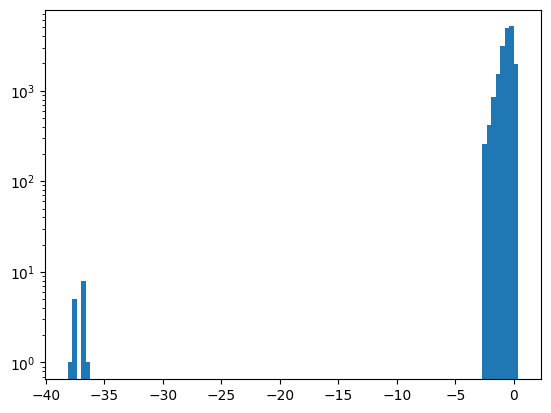

In [65]:
h = plt.hist(np.log(nodes_dist),bins=100)
plt.gca().set_yscale('log')

In [35]:
i = 190

el = elements[i]
plt.plot(nodes[[el[0],el[1],el[3],el[2]],0], nodes[[el[0],el[1],el[3],el[2]],1])
plt.scatter(nodes[[el[0],el[1],el[3],el[2]],0], nodes[[el[0],el[1],el[3],el[2]],1],c=np.arange(4))
plt.colorbar()

IndexError: index 190 is out of bounds for axis 0 with size 161

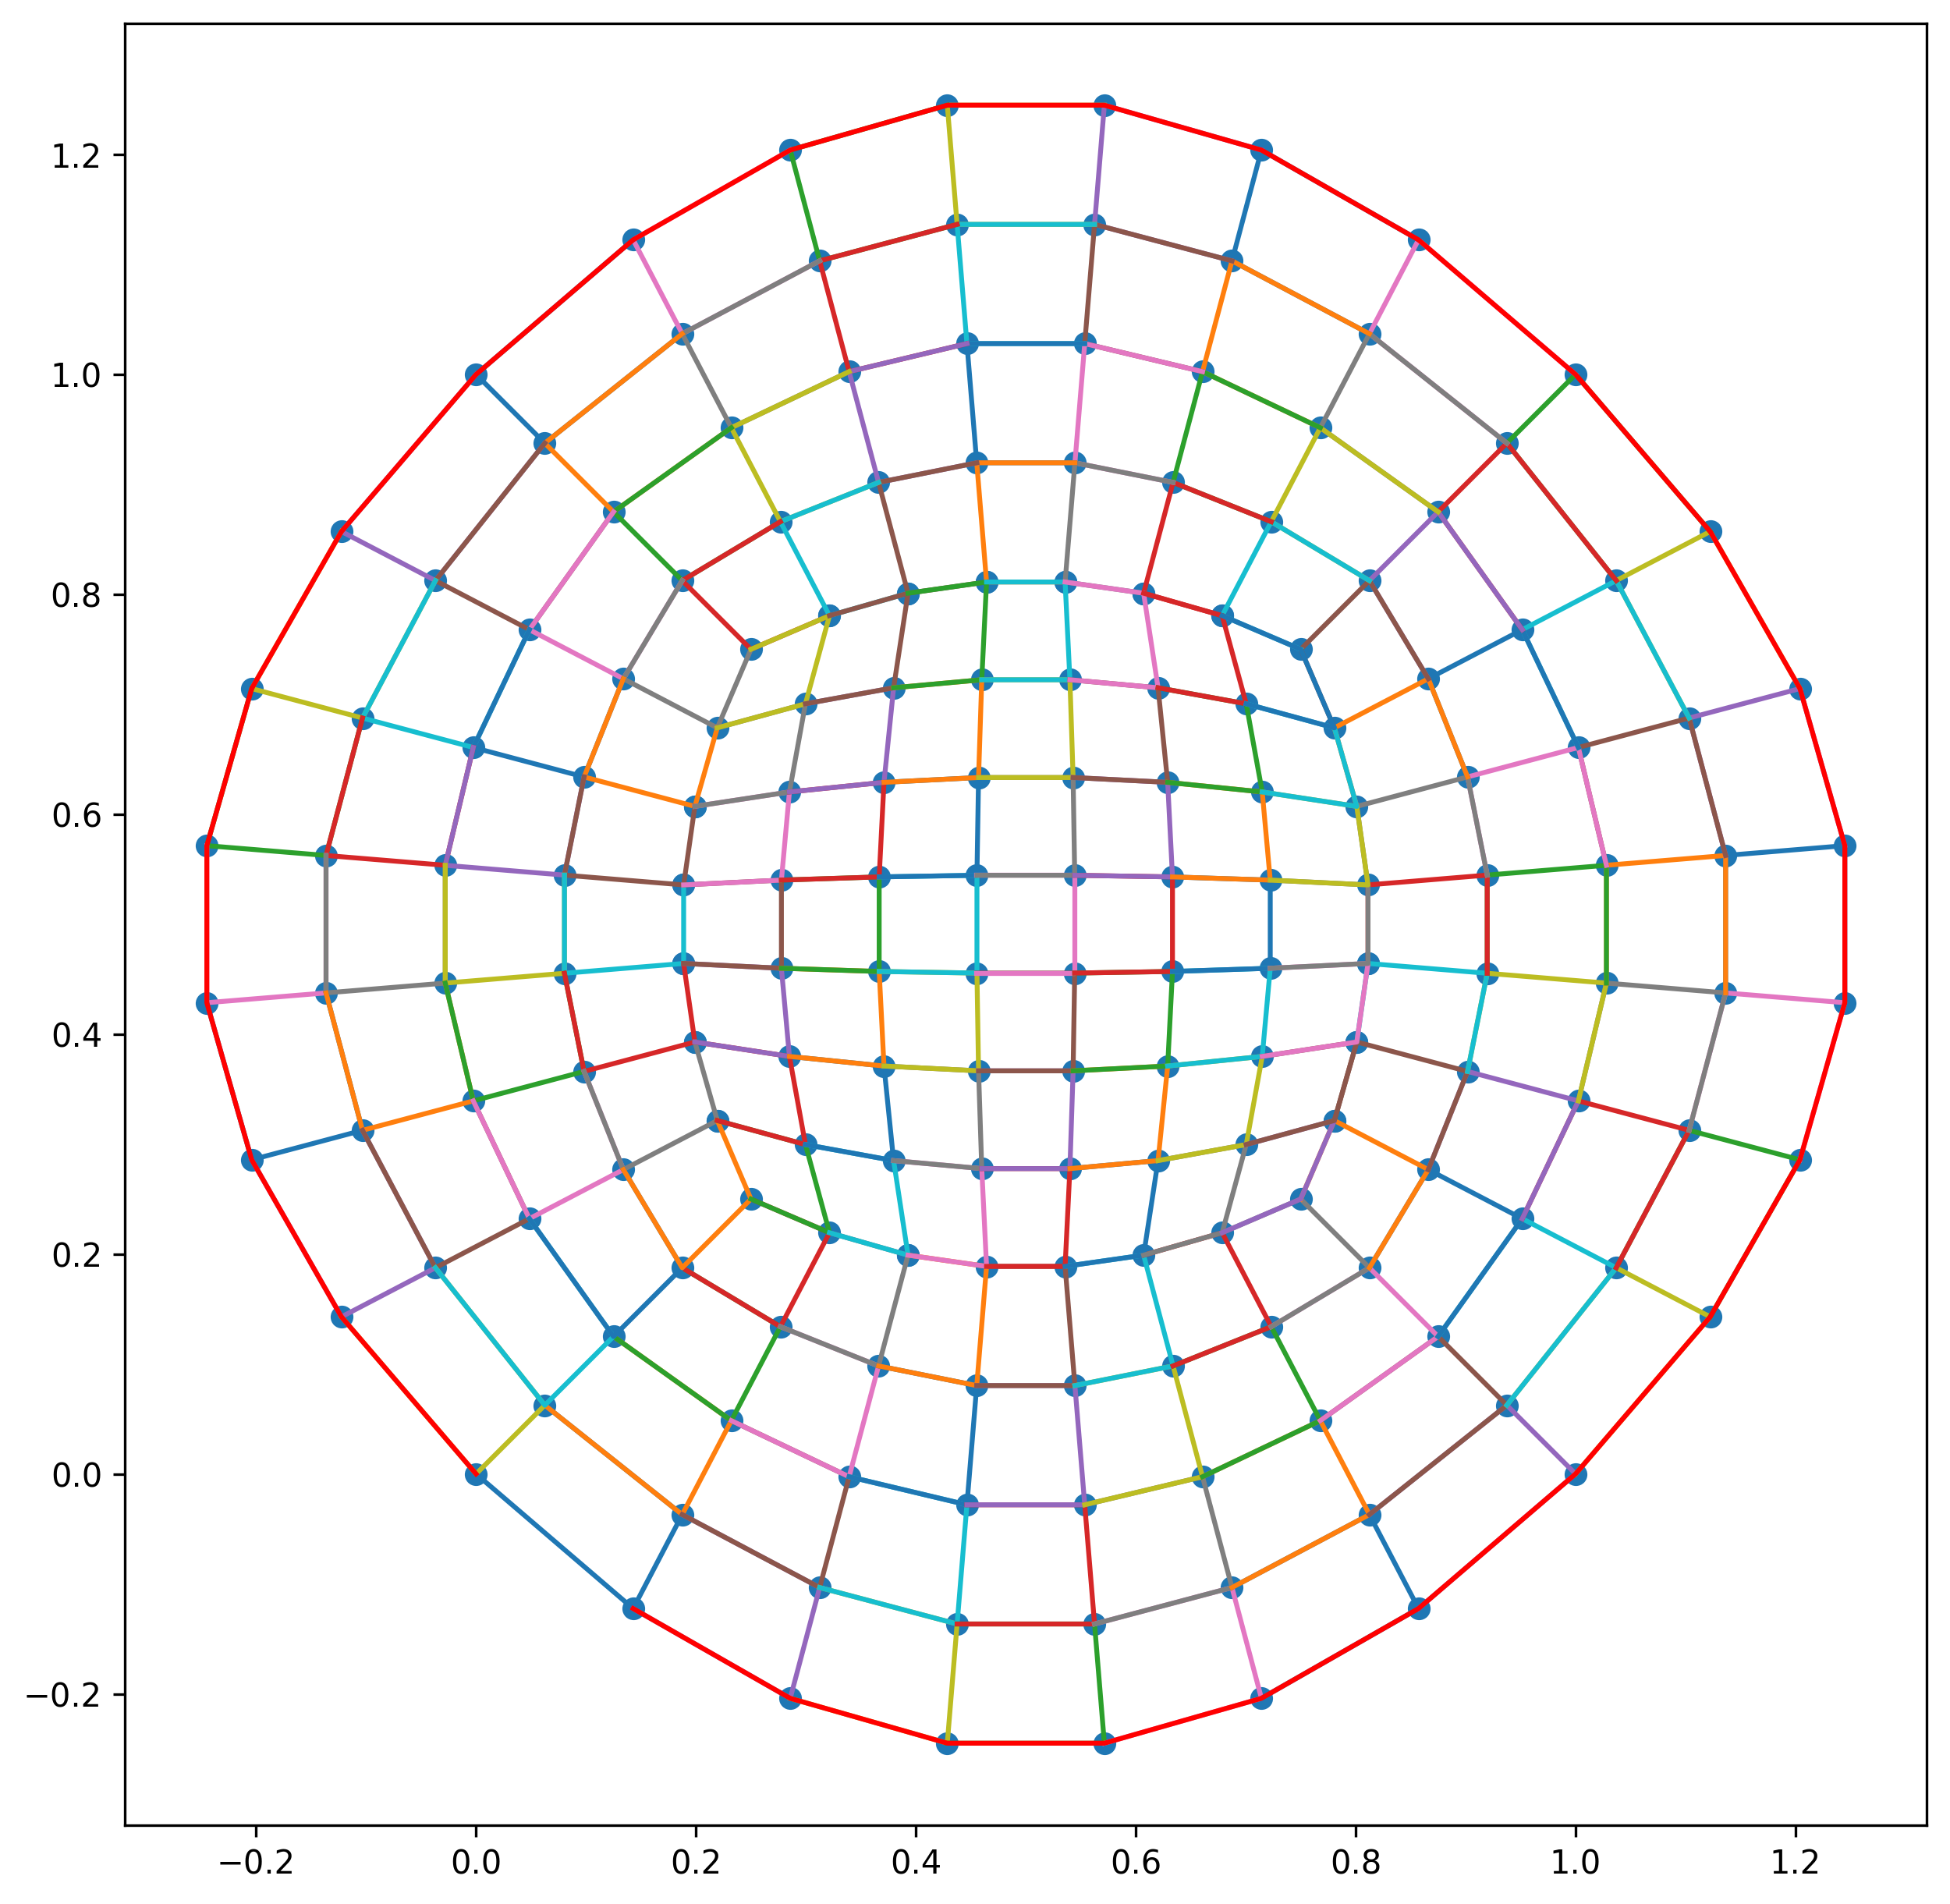

In [16]:
def PlotMesh2(nodes, boundaryNodes, elements):
    plt.figure(figsize=(10,10),dpi=300)
    plt.scatter(nodes[:,0],nodes[:,1])
    for el in elements:
        plt.plot(nodes[[el[0],el[1],el[3],el[2]],0], nodes[[el[0],el[1],el[3],el[2]],1])
    plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

PlotMesh2(nodes, boundaryNodes, elements)

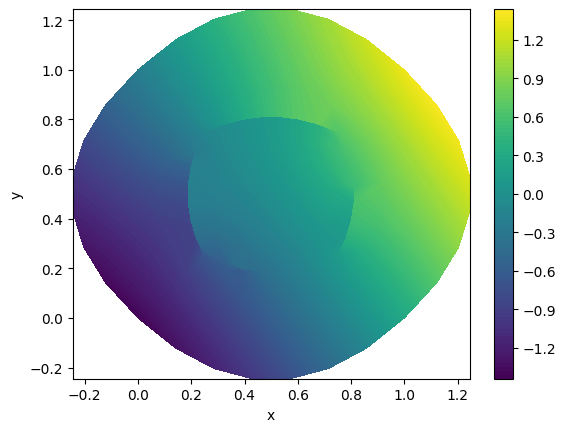

In [8]:
# Convert quadrlateral mesh to triangular mesh
triangles = np.concatenate([elements[:,:3],elements[:,1:]],0)

# Create a Triangulation object
triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], triangles)

# Plotting
plt.figure()
plt.tricontourf(triangulation, l[:,0],100)
plt.colorbar()
# plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [247]:
n = 10
xi,eta = np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n))
xi = xi.reshape(n,n,1)
eta = eta.reshape(n,n,1)


N = np.concatenate([
    0.25 * (1 - xi) * (1 - eta) * (-1 - xi - eta),
    0.25 * (1 + xi) * (1 - eta) * (-1 + xi - eta),
    0.25 * (1 + xi) * (1 + eta) * (-1 + xi + eta),
    0.25 * (1 - xi) * (1 + eta) * (-1 - xi + eta),
    0.5 * (1 - xi**2) * (1 - eta),
    0.5 * (1 + xi) * (1 - eta**2),
    0.5 * (1 - xi**2) * (1 + eta),
    0.5 * (1 - xi) * (1 - eta**2)
],axis=-1)
N = np.expand_dims(N,axis=-2)

p = np.array([[0,0],[1,0],[1,1],[0,1],[0.5,-0.1],[1.1,0.5],[0.5,1.1],[-0.1,0.5]])
grid = N @ p

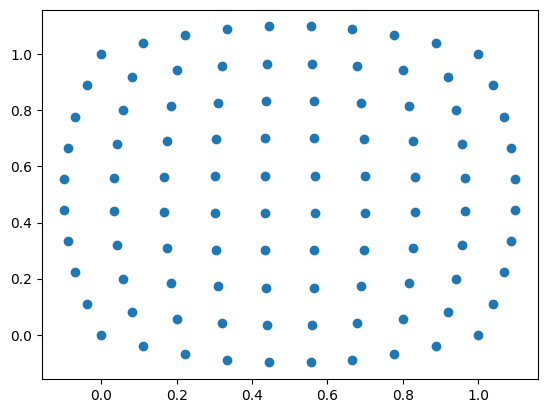

In [248]:
plt.scatter(grid[:,:,0,0],grid[:,:,0,1])

In [240]:
(0.25 * (1 - xi) * (1 - eta) * (-1 - xi - eta)).shape

(5, 5)